General DESI related packages

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import specsim
import specsim.quickspecsim as qspecsim
import specsim.instrument as inst
import specsim.source as src
import specsim.config as conf
import specsim.fiberloss as floss
import specsim.observation as obs
import specsim.simulator as sim
import specsim.atmosphere as atm

from desisim import io
from desisim import obs

import astropy.units as u
import astropy.table

num_source = 1

Construct the models

In [2]:
desi_configs = ['desi-blur', 'desi-blur-offset', 'desi-blur-offset-scale', 'desi-blur-offset-scale-stochastic']
config_path = '/home/tyapici/Projects/DESI_projects/dithering/config/'
desi_models = {}

# run the specsim.simulator with a configuration at "model"
def desi_model(model):
    return sim.Simulator(config_path+model+'.yaml')

# generate all relevant configurations for future use
for config in desi_configs:
    desi_models[config] = desi_model(config)

# default model is set to desi+blur+offset
curr_desi_model = desi_models['desi-blur-offset']

In [3]:
# function to generate the wavelength values
def create_wlen_grid(num_wlen=11, desi=curr_desi_model):
    wavelength = desi.simulated['wavelength']
    wlen_unit = wavelength.unit
    return np.linspace(wavelength.data[0], wavelength.data[-1], num_wlen) * wlen_unit
# generate the wavelengths array
wlen_grid = create_wlen_grid()

In [4]:
# function to generate the positions of the fibers.
# TODO: it is done with random positions, need to change with the actual positions
def generate_fiber_positions(nfiber=5000, seed=13, desi=curr_desi_model, isRandom=True):
    if isRandom:
        gen = np.random.RandomState(seed)
        focal_r = (np.sqrt(gen.uniform(size=nfiber)) * desi.instrument.field_radius)
        phi = 2 * np.pi * gen.uniform(size=nfiber)
    else:
        # this part is broken. needs some fixing
        gen = np.random.RandomState(seed)
        focal_r = (np.sqrt(gen.uniform(0, 0.001, size=nfiber)) * desi.instrument.field_radius)
        phi = 2 * np.pi * gen.uniform(size=nfiber)
    return np.cos(phi) * focal_r, np.sin(phi) * focal_r

focal_x, focal_y = generate_fiber_positions(num_source, isRandom=True)

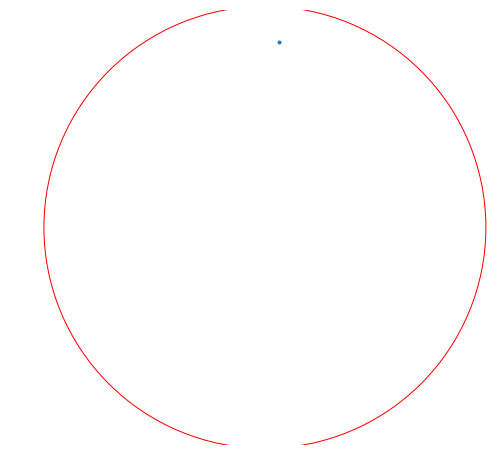

In [5]:
# function to plot the fiber positions nicely
def plot_fiber_positions(save=None, desi=curr_desi_model, select=None):
    plt.figure(figsize=(8, 8))
    x, y = focal_x.to(u.mm).value, focal_y.to(u.mm).value
    plt.plot(x, y, '.')
    if select is not None:
        plt.scatter(x[select], y[select], s=100)
    r = 1.05 * desi.instrument.field_radius.to(u.mm).value
    plt.xlim(-1.01 * r, +1.01 * r)
    plt.ylim(-1.01 * r, +1.01 * r)
    plt.gca().set_aspect('equal', 'datalim')
    plt.gca().add_artist(plt.Circle((0, 0), r, color='r', fill=False))
    plt.axis('off')
    if save:
        plt.savefig(save)
    else:
        plt.show()
        
plot_fiber_positions()

In [32]:
# function to generate mock sources
def generate_sources(nsrc=5000, disk_fraction=1., bulge_fraction=0., vary='', seed=23, minormajor=[1,1]):
    gen = np.random.RandomState(seed)
    varied = vary.split(',')
    source_fraction = np.tile([disk_fraction, bulge_fraction], (nsrc, 1))
    source_half_light_radius = np.tile([0.45, 1.0], (nsrc, 1))
    source_minor_major_axis_ratio = np.tile(minormajor, (nsrc, 1))
    if 'pa' in varied:
        source_position_angle = 360. * gen.uniform(size=(nsrc, 2))
    else:
        source_position_angle = np.tile([0., 0.], (nsrc, 1))
    return source_fraction, source_half_light_radius, source_minor_major_axis_ratio, source_position_angle

# the source information will be used later on for the fiber loss calculation
# using their expected spectrum

# Round sources are generated here
qsos_round = generate_sources(num_source, 0., 0., seed=1)
elgs_round = generate_sources(num_source, 1., 0., seed=1)
lrgs_round = generate_sources(num_source, 0., 1., seed=1)

# elliptic objects are generated here
qsos_elliptic = generate_sources(num_source, 0., 0., seed=1, minormajor=[0.4, 0.6])
elgs_elliptic = generate_sources(num_source, 1., 0., seed=1, minormajor=[0.4, 0.6])
lrgs_elliptic = generate_sources(num_source, 0., 1., seed=1, minormajor=[0.4, 0.6])

In [20]:
def calculateFiberLoss(desi=curr_desi_model):
    calc = floss.GalsimFiberlossCalculator(desi.instrument.fiber_diameter.to(u.um).value,
                                           wlen_grid.to(u.Angstrom).value,
                                           num_pixels=16, oversampling=32, moffat_beta=3.5)
    return calc

In [21]:
def get_fiberloss(source_fraction, source_half_light_radius, source_minor_major_axis_ratio,
                  source_position_angle,
                  x=focal_x, y=focal_y, seeing=1.1*u.arcsec, desi=curr_desi_model):
    # Subtract instrumental PSF.
    #Jacoby = 0.219
    #seeing = 2.35482 * np.sqrt((seeing.to(u.arcsec).value/2.35482) ** 2 - Jacoby**2) * u.arcsec
    # Tabulate seeing.
    #desi.atmosphere.seeing_fwhm_ref = seeing
    seeing_fwhm = desi.atmosphere.get_seeing_fwhm(wlen_grid).to(u.arcsec).value
    # Calculate optics.
    # NOTE: TODO: may add dithering stuff here
    
    scale, blur, offset = desi.instrument.get_focal_plane_optics(x, y, wlen_grid)
    # Do the fiberloss calculations.
    calc = calculateFiberLoss(desi=desi)
    return calc.calculate(seeing_fwhm,
                          scale.to(u.um / u.arcsec).value, offset.to(u.um).value,
                          blur.to(u.um).value,
                          source_fraction, source_half_light_radius,
                          source_minor_major_axis_ratio, source_position_angle)

In [24]:
def get_desimodel_fiberloss(obj_type='lrg'):
    path = os.path.join(os.environ['DESIMODEL'], 'data', 'throughput',
                        'fiberloss-{0}.dat'.format(obj_type))
    t = astropy.table.Table.read(path, format='ascii', names=['wlen', 'accept'])
    return t

In [23]:
def plot_fiberloss(floss, cmap_name='viridis', alpha=0.1, ylim=(None, None),
                   desi=curr_desi_model, desimodel_type=None, save=None, overlay=False):
    if not overlay:
        plt.figure(figsize=(5, 4))
    wlen = wlen_grid.value
    rvalues = np.sqrt(focal_x ** 2 + focal_y ** 2)
    norm = matplotlib.colors.Normalize(
        vmin=0., vmax=desi.instrument.field_radius.to(u.mm).value)
    sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap(cmap_name))
    for f, r in zip(floss, rvalues):
        color = sm.to_rgba(r)
        p = plt.plot(wlen, f, ls='-', c=color, alpha=0.2)
    plt.plot(wlen, np.median(floss, axis=0), 'k-', lw=2, label='median')
    if desimodel_type:
        t = get_desimodel_fiberloss(desimodel_type)
        plt.plot(t['wlen'], t['accept'], 'r--', lw=2, label='desimodel')
    if not overlay:
        plt.ylim(*ylim)
        # Very useful trick from http://stackoverflow.com/posts/11558629/revisions
        sm._A = []
        plt.colorbar(sm).set_label('Radius [mm]')
        plt.xlabel('Wavelength [Angstrom]')
        plt.ylabel('Fiber accepetance fraction')
        plt.xlim(wlen[0], wlen[-1])
        plt.tight_layout()
    if save:
        plt.savefig(save)

In [60]:
def plot_one_fiberloss(floss, ix, iy, cmap_name='viridis', alpha=0.1, ylim=(None, None),
                       desi=curr_desi_model, desimodel_type=None, save=None, overlay=False):
    wlen = wlen_grid.value
    line_median, = plt.plot(wlen, np.median(floss, axis=0), 'k-', lw=2, label='dx=%d dy=%d'%(ix*5, iy*5))
    return line_median

In [49]:
desi = curr_desi_model
f_qso_round  = get_fiberloss(*qsos_round, desi=desi, x=focal_x, y=focal_y)
f_elgs_round = get_fiberloss(*elgs_round, desi=desi)
f_lrgs_round = get_fiberloss(*lrgs_round, desi=desi)
f_qso_elliptic  = get_fiberloss(*qsos_elliptic, desi=desi)
f_elgs_elliptic = get_fiberloss(*elgs_elliptic, desi=desi)
f_lrgs_elliptic = get_fiberloss(*lrgs_elliptic, desi=desi)

In [65]:
dither = np.linspace(-10, 10, 20)
for ix in range(20):
    for iy in range(20):
        f_qso_round  = get_fiberloss(*qsos_round, desi=desi, x=focal_x+dither[ix]*5*u.mm, y=focal_y+dither[iy]*5.*u.mm)
        l1 = plot_one_fiberloss(f_qso_round, ix, iy, ylim=(0.18, 0.68), desimodel_type='qso', save="figures/qso_round_fiberloss_%d.png"%(dither[i]))
t = get_desimodel_fiberloss('qso')
line_model, = plt.plot(t['wlen'], t['accept'], 'r--', lw=2, label='desimodel')
#plt.show()
plt.savefig("figures/ugly_plot.png")

In [44]:
plot_fiberloss(f_qso_round, ylim=(0.18, 0.68), desimodel_type='qso', save="qso_round_fiberloss_1.png")
plot_fiberloss(f_qso_elliptic, ylim=(0.18, 0.68), desimodel_type='qso', save="qso_elliptic_fiberloss_1.png")

In [17]:
plot_fiberloss(f_elgs_round, ylim=(0.18, 0.68), desimodel_type='elg', save="elg_round_fiberloss.png")
plot_fiberloss(f_elgs_elliptic, ylim=(0.18, 0.68), desimodel_type='elg', save="elg_elliptic_fiberloss.png")

In [16]:
plot_fiberloss(f_lrgs_round, ylim=(0.18, 0.68), desimodel_type='lrg', save="lrg_round_fiberloss.png")
plot_fiberloss(f_lrgs_elliptic, ylim=(0.18, 0.68), desimodel_type='lrg', save="lrg_elliptic_fiberloss.png")

In [37]:
#plt.clf()
#fig1 = plt.figure(1,1)
#c = specsim.config.load_config(config_path+"desi-blur"+".yaml")
#i = specsim.instrument.initialize(c)
#i.plot()
#plt.show()
#i.plot_field_distortion()
#plt.show()